# Requirements

In [ ]:
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import MinMaxScaler

# Load dataset

In [ ]:
df = pd.read_csv('../input/digit-recognizer/train.csv')
df

# Build labels

In [ ]:
y_data = df.pop("label")
y_data

In [ ]:
import numpy as np
from sklearn import preprocessing


def transform_labels(labels_array, labels):
    lb = preprocessing.LabelBinarizer()
    lb.fit(labels)
    new_labels_array = []
    for l in labels_array:
        transformed_labels = lb.transform([l])
        transformed_labels = transformed_labels.reshape((transformed_labels.shape[1],))
        new_labels_array.append(transformed_labels)

    new_labels_array = np.array(new_labels_array)
    return new_labels_array

y_data = transform_labels(y_data, list(range(0, 10)))
y_data

# Build images

In [ ]:
X_data = df.to_numpy()
print(X_data.shape)
X_data = X_data.reshape((X_data.shape[0], 28, 28, 1))
X_data.shape

# Normalize images

![](https://docs.microsoft.com/pt-br/azure/machine-learning/algorithm-module-reference/media/module/aml-normalization-minmax.png)

In [ ]:
X_data = X_data / 255

# Plot images

In [ ]:
import matplotlib.pyplot as plt

i = 10
plt.imshow(X_data[i].reshape((28, 28)))
print(y_data[i])

# Create CNN model

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import RMSprop


def model_fn(input_shape, classes):
    x_inputs = Input(input_shape)

    x = Conv2D(filters = 64, kernel_size = (5,5), activation ='relu')(x_inputs)
    x = BatchNormalization()(x)
    x = Conv2D(filters = 64, kernel_size = (5,5), activation ='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = Dropout(0.10)(x)

    x = Conv2D(filters = 128, kernel_size = (3,3), activation ='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters = 128, kernel_size = (3,3), activation ='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(filters = 512, kernel_size = (3,3), activation ='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    x = Dense(1024, activation = "relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(10, activation = "softmax")(x)
    
    model = Model(inputs=x_inputs, outputs=x)
    
    model.compile(loss="categorical_crossentropy",
                  optimizer='adam',
                  metrics=["accuracy"])

    return model

In [ ]:
from IPython.display import Image


model = model_fn((28, 28, 1), 10)


tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image("model.png")

# Create checkpoint callback

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
model_dir = '/kaggle/working/'
checkpoint_path = "{dir}/model.ckpt".format(dir=model_dir)

latest = tf.train.latest_checkpoint(model_dir)

if latest:
    print("Loading model...")
    model.load_weights(latest)

# Save model
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', min_delta=0, patience=5, verbose=0,
                mode='auto',
                baseline=None, restore_best_weights=True
            )



callbacks = [checkpoint, early_stopping]

# Split train and test sets

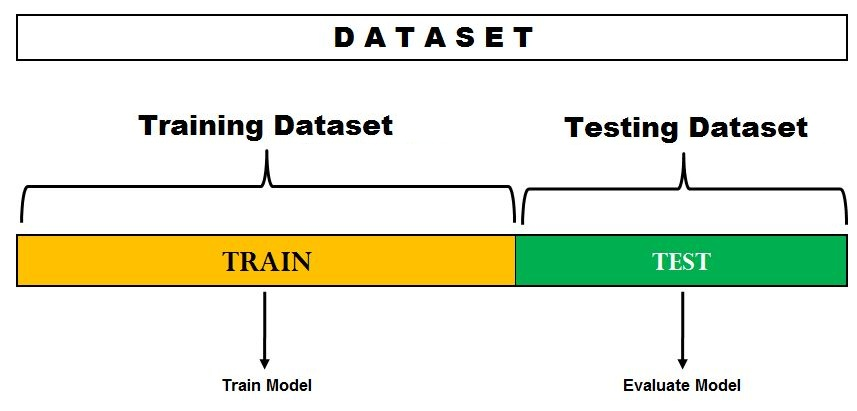

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                  test_size=0.1,
                                                  random_state=1)

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,
                                                  test_size=0.1,
                                                  random_state=1)

X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

# Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Data Augmentation 
datagen = ImageDataGenerator(
        featurewise_center=False, # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

# Training model

In [ ]:
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=256),
                              epochs = 100, 
                              validation_data = (X_validation, y_validation),
                              verbose = 1,
                              use_multiprocessing=True,
                              workers=4,
                              callbacks=callbacks)

# Draw the loss and accuracy curves

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# Load best model

In [ ]:
latest = tf.train.latest_checkpoint(model_dir)

if latest:
    print("Loading model...")
    model.load_weights(latest)

# Testing model

In [ ]:
test_results = model.evaluate(X_test, y_test, batch_size=1024)

# Predict test data

In [ ]:
test_df = pd.read_csv('../input/digit-recognizer/test.csv')

X_predict = test_df.to_numpy()

X_predict = X_predict.reshape((X_predict.shape[0], 28, 28, 1))

reescaled_data = []
for x in X_predict:
    reescaled_image = (x - x.min(axis=0)) / ((x.max(axis=0) - x.min(axis=0) + 0.0000001))
    reescaled_data.append(reescaled_image)

X_predict = np.array(reescaled_data)

predicted = model.predict(X_predict)
predicted_values = np.array(tf.argmax(predicted, axis=1))

my_submission = pd.DataFrame({'ImageId': list(range(1, len(predicted_values)+1)), 'Label': predicted_values})
my_submission.to_csv('submission.csv', index=False)